In [68]:
import pandas as pd
pd.set_option('display.max_columns', None)
import pickle
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader
from tqdm.notebook import tqdm
import time
import matplotlib.pyplot as plt
import os

rnd = 42
np.random.seed(rnd)
torch.manual_seed(rnd)

In [69]:
from sklearn.preprocessing import OrdinalEncoder, MinMaxScaler, OneHotEncoder
from sklearn.model_selection import train_test_split
from collections import defaultdict

def get_features_map(feature_names, real_feature_names):
    features_map = defaultdict(dict)
    i = 0
    j = 0

    while i < len(feature_names) and j < len(real_feature_names):
        if feature_names[i] == real_feature_names[j]:
            features_map[j][feature_names[i].replace('%s=' % real_feature_names[j], '')] = i
            i += 1
            j += 1
        elif feature_names[i].startswith(real_feature_names[j]):
            features_map[j][feature_names[i].replace('%s=' % real_feature_names[j], '')] = i
            i += 1
        else:
            j += 1
    return features_map

def get_real_feature_names(rdf, numeric_columns, class_name):
    if isinstance(class_name, list):
        real_feature_names = [c for c in rdf.columns if c in numeric_columns and c not in class_name]
        real_feature_names += [c for c in rdf.columns if c not in numeric_columns and c not in class_name]
    else:
        real_feature_names = [c for c in rdf.columns if c in numeric_columns and c != class_name]
        real_feature_names += [c for c in rdf.columns if c not in numeric_columns and c != class_name]
    return real_feature_names

def one_hot_encoding(df, class_name):
    if not isinstance(class_name, list):
        dfX = pd.get_dummies(df[[c for c in df.columns if c != class_name]], prefix_sep='=')
        class_name_map = {v: k for k, v in enumerate(sorted(df[class_name].unique()))}
        dfY = df[class_name].map(class_name_map)
        df = pd.concat([dfX, dfY], axis=1)
        df =df.reindex(dfX.index)
        feature_names = list(dfX.columns)
        class_values = sorted(class_name_map)
    else: # isinstance(class_name, list)
        dfX = pd.get_dummies(df[[c for c in df.columns if c not in class_name]], prefix_sep='=')
        # class_name_map = {v: k for k, v in enumerate(sorted(class_name))}
        class_values = sorted(class_name)
        dfY = df[class_values]
        df = pd.concat([dfX, dfY], axis=1)
        df = df.reindex(dfX.index)
        feature_names = list(dfX.columns)
    return df, feature_names, class_values

def remove_missing_values(df):
    for column_name, nbr_missing in df.isna().sum().to_dict().items():
        if nbr_missing > 0:
            if column_name in df._get_numeric_data().columns:
                mean = df[column_name].mean()
                df[column_name].fillna(mean, inplace=True)
            else:
                mode = df[column_name].mode().values[0]
                df[column_name].fillna(mode, inplace=True)
    return df

def get_numeric_columns(df):
    numeric_columns = list(df._get_numeric_data().columns)
    return numeric_columns

class_name = 'default'
# Load and transform dataset 
df = pd.read_csv('./data/german_credit.csv', skipinitialspace=True, na_values='?', keep_default_na=True)
df.columns = [c.replace('=', '') for c in df.columns]

df = remove_missing_values(df)
numeric_columns = get_numeric_columns(df)
rdf = df
df, feature_names, class_values = one_hot_encoding(df, class_name)
real_feature_names = get_real_feature_names(rdf, numeric_columns, class_name)
rdf = rdf[real_feature_names + (class_values if isinstance(class_name, list) else [class_name])]
features_map = get_features_map(feature_names, real_feature_names)
std = MinMaxScaler(feature_range=(-1,1))
df.iloc[:,[0,1,4]] = std.fit_transform(df.values[:,[0,1,4]])
hot_enc = OneHotEncoder(handle_unknown='ignore')
for i in [2,3,5,6]:
    df.iloc[:,i] = [df.columns[i]+'='+df.iloc[:,i].values.astype(str)[j] for j in range(len(df))] 
hot_enc.fit(df.iloc[:,[2,3,5,6]])
df[np.hstack(hot_enc.categories_).tolist()]=hot_enc.transform(df.iloc[:,[2,3,5,6]]).toarray().astype(int)
df = df.drop(list(df.columns[[2,3,5,6]]), axis=1, inplace=False)
y = df['default'].astype(int)
df.drop(['default'], axis=1, inplace=True)

X_train, X_test, y_train, y_test = train_test_split(df.values, y, test_size=0.2, stratify=y, random_state=rnd)

In [70]:
df

,duration_in_month,credit_amount,age,account_check_status=0 <= ... < 200 DM,account_check_status=< 0 DM,account_check_status=>= 200 DM / salary assignments for at least 1 year,account_check_status=no checking account,credit_history=all credits at this bank paid back duly,credit_history=critical account/ other credits existing (not at this bank),credit_history=delay in paying off in the past,credit_history=existing credits paid back duly till now,credit_history=no credits taken/ all credits paid back duly,purpose=(vacation - does not exist?),purpose=business,purpose=car (new),purpose=car (used),purpose=domestic appliances,purpose=education,purpose=furniture/equipment,purpose=radio/television,purpose=repairs,purpose=retraining,savings=.. >= 1000 DM,savings=... < 100 DM,savings=100 <= ... < 500 DM,savings=500 <= ... < 1000 DM,savings=unknown/ no savings account,present_emp_since=.. >= 7 years,present_emp_since=... < 1 year,present_emp_since=1 <= ... < 4 years,present_emp_since=4 <= ... < 7 years,present_emp_since=unemployed,personal_status_sex=female : divorced/separated/married,personal_status_sex=male : divorced/separated,personal_status_sex=male : married/widowed,personal_status_sex=male : single,other_debtors=co-applicant,other_debtors=guarantor,other_debtors=none,property=if not A121 : building society savings agreement/ life insurance,"property=if not A121/A122 : car or other, not in attribute 6",property=real estate,property=unknown / no property,other_installment_plans=bank,other_installment_plans=none,other_installment_plans=stores,housing=for free,housing=own,housing=rent,job=management/ self-employed/ highly qualified employee/ officer,job=skilled employee / official,job=unemployed/ unskilled - non-resident,job=unskilled - resident,telephone=none,"telephone=yes, registered under the customers name",foreign_worker=no,foreign_worker=yes,installment_as_income_perc=1,installment_as_income_perc=2,installment_as_income_perc=3,installment_as_income_perc=4,present_res_since=1,present_res_since=2,present_res_since=3,present_res_since=4,credits_this_bank=1,credits_this_bank=2,credits_this_bank=3,credits_this_bank=4,people_under_maintenance=1,people_under_maintenance=2
0,-0.941176,-0.898867,0.714286,0,1,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,0,1,0,1,0,0,0,1,0,0,0,1,0,1,0,0,1,0
1,0.294118,-0.372620,-0.892857,1,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,1,0,0,0,0,0,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,1,0,1,0,0,0,1,0,0,1,0,0,0,1,0
2,-0.764706,-0.796853,0.071429,0,0,0,1,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,0,0,1,1,0,0,1,0,1,0,0,0,0,1,0,1,0,0,0,0,1
3,0.117647,-0.160119,-0.071429,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,1,0,1,0,1,0,0,0,0,1,0,1,0,0,0,1,0,0,1,0,0,1,0,1,0,0,0,0,0,1,1,0,0,0,0,1
4,-0.411765,-0.491581,0.214286,0,1,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,1,0,0,1,0,0,0,1,0,1,0,1,0,0,0,1,0,0,1,0,0,1,0,0,1,0,0,0,0,1,0,1,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,-0.764706,-0.836470,-0.571429,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,1,0,1,0,0,0,0,0,1,0,0,1,0,0,1,0,0,1,0,0,0,0,1,1,0,0,1,0,0,1,0,0,0,0,1,1,0,0,0,1,0
996,-0.235294,-0.603059,-0.250000,0,1,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,1,0,0,0,0,1,1,0,0,0,0,1,0,0,1,0,1,0,0,0,0,1,0,1,0,0,0,1,0,0,0,1,1,0,0,0,1,0
997,-0.764706,-0.939034,-0.321429,0,0,0,1,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,1,0,0,1,0,1,0,0,0,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,0,1,0,0,0,1,1,0,0,0,1,0
998,0.205882,-0.824475,-0.857143,0,1,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,1,0,0,1,0,0,0,1,0,1,0,1,0,0,0,1,0,0,0,1,0,1,0,0,0,1,0,0,0,1,1,0,0

In [71]:
df = pd.read_csv('./data/german_credit.csv', skipinitialspace=True, na_values='?', keep_default_na=True)
df.columns = [c.replace('=', '') for c in df.columns]
df = remove_missing_values(df)
y = df['default'].astype(int)
df.drop(['default'], axis=1, inplace=True)
l = list(df.columns)
l.remove('duration_in_month')
l.remove('age')
l.remove('credit_amount')
df = df.loc[:,['duration_in_month','credit_amount','age']+l]
std = MinMaxScaler(feature_range=(-1,1))
df.iloc[:,:3] = std.fit_transform(df.values[:,:3])
hot_enc = OneHotEncoder(handle_unknown='ignore')
hot_enc.fit(df.iloc[:,3:])
df[np.hstack(hot_enc.categories_).tolist()]=hot_enc.transform(df.iloc[:,3:]).toarray().astype(int)
#df.drop(l, axis=1, inplace=True)
#X_train, X_test, y_train, y_test = train_test_split(df, y, test_size=0.2, stratify=y, random_state=rnd)

### XGBOOST

In [4]:
from xgboost import XGBClassifier
clf_xgb = XGBClassifier(n_estimators=10, reg_lambda=1, use_label_encoder=False, eval_metric='logloss')
clf_xgb.fit(X_train, y_train)
pickle.dump(clf_xgb,open('./BlackBoxes/german_xgboost.p','wb'))

clf_xgb = pickle.load(open('./BlackBoxes/german_xgboost.p','rb'))
def predict(x, return_proba=False):
    if return_proba:
        return clf_xgb.predict_proba(x)[:,1].ravel()
    else: return clf_xgb.predict(x).ravel().ravel()
y_train_pred = predict(X_train)
y_test_pred = predict(X_test)
print('XGBOOST')
print('train acc:',np.mean(np.round(y_train_pred)==y_train))
print('test acc:',np.mean(np.round(y_test_pred)==y_test))

XGBOOST
train acc: 0.93625
test acc: 0.75


### RF

In [5]:
from sklearn.ensemble import RandomForestClassifier

clf_rf = RandomForestClassifier(max_depth=7,random_state=rnd)
clf_rf.fit(X_train, y_train)

pickle.dump(clf_rf,open('./BlackBoxes/german_rf.p','wb'))
clf_rf

RandomForestClassifier(max_depth=7, random_state=42)

In [6]:
clf_rf = pickle.load(open('./BlackBoxes/german_rf.p','rb'))

def predict(x, return_proba=False):
    if return_proba:
        return clf_rf.predict_proba(x)[:,1].ravel()
    else: return clf_rf.predict(x).ravel().ravel()

y_test_pred = predict(X_test, return_proba=True)
y_train_pred = predict(X_train, return_proba=True)
print('train acc:',np.mean(np.round(y_train_pred)==y_train))
print('test acc:',np.mean(np.round(y_test_pred)==y_test))

train acc: 0.875
test acc: 0.77


### SVC

In [7]:
from sklearn.svm import SVC
clf_svc = SVC(gamma='auto', probability=True)
clf_svc.fit(X_train, y_train)
pickle.dump(clf_svc,open('./BlackBoxes/german_svc.p','wb'))

clf_svc = pickle.load(open('./BlackBoxes/german_svc.p','rb'))

def predict(x, return_proba=False):
    if return_proba:
        return clf_svc.predict_proba(x)[:,1].ravel()
    else: return clf_svc.predict(x).ravel().ravel()

y_train_pred = predict(X_train, return_proba=True)
y_test_pred = predict(X_test, return_proba=True)
print('SVC')
print('train acc:',np.mean(np.round(y_train_pred)==y_train))
print('test acc:',np.mean(np.round(y_test_pred)==y_test))

SVC
train acc: 0.79375
test acc: 0.77


### NN tf

/Users/francescobodria/anaconda3/envs/latent_space/lib/python3.7/site-packages/tensorflow/python/keras/engine/training.py:2366: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`Model.state_updates` will be removed in a future version. '


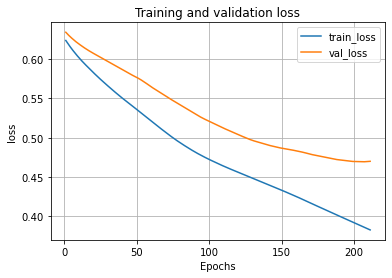

NN
0.8375
0.8
---------------


In [73]:
# ### NN tf

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.callbacks import EarlyStopping

BATCH_SIZE = 1024
train_dataset = tf.data.Dataset.from_tensor_slices((X_train, y_train)).shuffle(2048).batch(BATCH_SIZE)
test_dataset = tf.data.Dataset.from_tensor_slices((X_test, y_test)).batch(BATCH_SIZE)

clf_nn = keras.Sequential([
    keras.layers.Dense(units=10, activation='relu'),
    keras.layers.Dense(units=5, activation='relu'),
    keras.layers.Dense(units=1, activation='sigmoid'),
])

early_stopping = EarlyStopping(patience=5)

clf_nn.compile(optimizer='adam', 
              loss='binary_crossentropy',
              metrics=['accuracy'])

history = clf_nn.fit(
    train_dataset,
    validation_data=test_dataset,
    epochs=10000,
    callbacks=[early_stopping],
    verbose=0
    )

def plot_metric(history, metric):
    train_metrics = history.history[metric]
    val_metrics = history.history['val_'+metric]
    epochs = range(1, len(train_metrics) + 1)
    plt.plot(epochs, train_metrics)
    plt.plot(epochs, val_metrics)
    plt.title('Training and validation '+ metric)
    plt.xlabel("Epochs")
    plt.ylabel(metric)
    plt.grid()
    plt.legend(["train_"+metric, 'val_'+metric])
    plt.show()

plot_metric(history, 'loss')
clf_nn.save_weights('./blackboxes/german_tf_nn')

from sklearn.metrics import accuracy_score
clf_nn.load_weights('./blackboxes/german_tf_nn')
clf_nn.trainable = False

def predict(x, return_proba=False):
    if return_proba:
        return clf_nn.predict(x).ravel()
    else: return np.round(clf_nn.predict(x).ravel()).astype(int).ravel()

print('NN')
print(accuracy_score(np.round(predict(X_train, return_proba = True)),y_train))
print(accuracy_score(np.round(predict(X_test, return_proba = True)),y_test))
print('---------------')

In [74]:
black_box = 'nn'

if black_box=='xgb':
    def predict(x, return_proba=False):
        if return_proba:
            return clf_xgb.predict_proba(x)[:,1].ravel()
        else: return clf_xgb.predict(x).ravel().ravel()
    y_test_pred = predict(X_test, return_proba=True)
    y_train_pred = predict(X_train, return_proba=True)
elif black_box=='rf':
    def predict(x, return_proba=False):
        if return_proba:
            return clf_rf.predict_proba(x)[:,1].ravel()
        else: return clf_rf.predict(x).ravel().ravel()
    y_test_pred = predict(X_test, return_proba=True)
    y_train_pred = predict(X_train, return_proba=True)
elif black_box=='svc':
    def predict(x, return_proba=False):
        if return_proba:
            return clf_svc.predict_proba(x)[:,1].ravel()
        else: return clf_svc.predict(x).ravel().ravel()
    y_test_pred = predict(X_test, return_proba=True)
    y_train_pred = predict(X_train, return_proba=True)
elif black_box=='nn':
    def predict(x, return_proba=False):
        if return_proba:
            return clf_nn.predict(x).ravel()
        else: return np.round(clf_nn.predict(x).ravel()).astype(int).ravel()
    y_test_pred = predict(X_test, return_proba=True)
    y_train_pred = predict(X_train, return_proba=True)

# Latent Space

In [75]:
X_train = np.hstack((X_train,y_train_pred.reshape(-1,1)))
X_test = np.hstack((X_test,y_test_pred.reshape(-1,1)))

In [76]:
latent_dim = 10
alpha = 0.5
batch_size = 1024
sigma = 1
max_epochs = 10000
early_stopping = 3
learning_rate = 1e-3
idx_cat = np.arange(3,71,1).tolist()

similarity_KLD = torch.nn.KLDivLoss(reduction='batchmean')

def compute_similarity_Z(X, sigma):
    D = torch.cdist(X,X)
    M = torch.exp((-D**2)/(2*sigma**2))
    return M / (torch.ones([M.shape[0],M.shape[1]])*(torch.sum(M, axis = 0)-1)).transpose(0,1)

def compute_similarity_X(X, sigma, alpha, idx_cat=None):
    D_class = torch.cdist(X[:,-1].reshape(-1,1),X[:,-1].reshape(-1,1))
    X = X[:, :-1]
    if idx_cat:     
        X_cat = X[:, idx_cat]
        X_cont = X[:, np.delete(range(X.shape[1]),idx_cat)]
        h = X_cat.shape[1]
        m = X.shape[1]
        D_cont = torch.cdist(X_cont,X_cont)
        D_cat = torch.cdist(X_cat, X_cat, p=0)/h
        D = h/m * D_cat + ((m-h)/m) * D_cont + alpha * D_class
    else:
        D = torch.cdist(X,X) + alpha*D_class
    M = torch.exp((-D**2)/(2*sigma**2))
    return M / (torch.ones([M.shape[0],M.shape[1]])*(torch.sum(M, axis = 0)-1)).transpose(0,1)

def loss_function(X, Z, idx_cat, sigma=1):
    Sx = compute_similarity_X(X, sigma, alpha, idx_cat)
    Sz = compute_similarity_Z(Z, 1)
    loss = similarity_KLD(torch.log(Sx), Sz)
    return loss

class LinearModel(nn.Module):
    def __init__(self, input_shape, latent_dim=2):
        super(LinearModel, self).__init__()

        # encoding components
        self.fc1 = nn.Linear(input_shape, latent_dim)

    def encode(self, x):
        x = self.fc1(x)
        return x

    def forward(self, x):
        z = self.encode(x)
        return z

# Create Model
model = LinearModel(X_train.shape[1], latent_dim=latent_dim)

In [15]:
train_dataset = TensorDataset(torch.tensor(X_train).float())
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True) 
test_dataset = TensorDataset(torch.tensor(X_test).float())
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False) 

def check_and_clear(dir_name):
    if not os.path.exists(dir_name):
        os.mkdir(dir_name)
    else:
        os.system('rm -r ' + dir_name)
        os.mkdir(dir_name)

check_and_clear('./models/weights')

model_params = list(model.parameters())
optimizer = torch.optim.Adam(model_params, lr=learning_rate)

# record training process
epoch_train_losses = []
epoch_test_losses = []

#validation parameters
epoch = 1
best = np.inf

# progress bar
pbar = tqdm(bar_format="{postfix[0]} {postfix[1][value]:03d} {postfix[2]} {postfix[3][value]:.5f} {postfix[4]} {postfix[5][value]:.5f} {postfix[6]} {postfix[7][value]:d}",
            postfix=["Epoch:", {'value':0}, "Train Sim Loss", {'value':0}, "Test Sim Loss", {'value':0}, "Early Stopping", {"value":0}])

# start training
while epoch <= max_epochs:

    # ------- TRAIN ------- #
    # set model as training mode
    model.train()
    batch_loss = []

    for batch, (X_batch,) in enumerate(train_loader):
        optimizer.zero_grad()
        Z_batch = model(X_batch)  #
        loss  = loss_function(X_batch, Z_batch, idx_cat, sigma) 
        loss.backward()
        optimizer.step()
        batch_loss.append(loss.item())

    # save result
    epoch_train_losses.append(np.mean(batch_loss))
    pbar.postfix[3]["value"] = np.mean(batch_loss)

    # -------- VALIDATION --------

    # set model as testing mode
    model.eval()
    batch_loss = []

    with torch.no_grad():
        for batch, (X_batch,) in enumerate(test_loader):
            Z_batch = model(X_batch)
            loss = loss_function(X_batch, Z_batch, idx_cat, sigma)
            batch_loss.append(loss.item())

    # save information
    epoch_test_losses.append(np.mean(batch_loss))
    pbar.postfix[5]["value"] = np.mean(batch_loss)
    pbar.postfix[1]["value"] = epoch

    if epoch_test_losses[-1] < best:
        wait = 0
        best = epoch_test_losses[-1]
        best_epoch = epoch
        torch.save(model.state_dict(), f'./models/weights/LinearTransparent.pt')
    else:
        wait += 1
    pbar.postfix[7]["value"] = wait
    if wait == early_stopping:
        break    
    epoch += 1
    pbar.update()

model.load_state_dict(torch.load(f'./models/weights/LinearTransparent.pt'))
with torch.no_grad():
    model.eval()
    Z_train = model(torch.tensor(X_train).float()).cpu().detach().numpy()
    Z_test = model(torch.tensor(X_test).float()).cpu().detach().numpy()

torch.save(model.state_dict(), f'./models/german_latent_{black_box}_{latent_dim}_{str(alpha).replace(".", "")}.pt')

Epoch: 000 Train Sim Loss 0.00000 Test Sim Loss 0.00000 Early Stopping 0

In [77]:
model.load_state_dict(torch.load(f'./models/german_latent_{black_box}_{latent_dim}_{str(alpha).replace(".", "")}.pt'))
with torch.no_grad():
    model.eval()
    Z_train = model(torch.tensor(X_train).float()).cpu().detach().numpy()
    Z_test = model(torch.tensor(X_test).float()).cpu().detach().numpy()

In [78]:
idx = 0
predict(X_test[idx:idx+1,:-1],return_proba=True)

array([0.38046926], dtype=float32)

In [79]:
y_contrib = model.fc1.weight.detach().numpy()[:,-1]

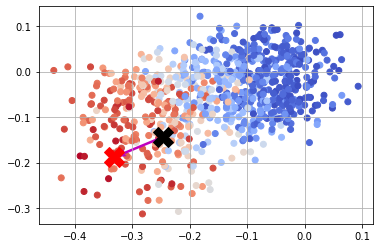

In [80]:
plt.scatter(Z_train[:,0], Z_train[:,1], c=y_train_pred, cmap='coolwarm')
plt.plot(Z_test[idx,0], Z_test[idx,1], 'kX', markersize=20)
m = +0.3
plt.plot(Z_test[idx,0]+m*y_contrib[0], Z_test[idx,1]+m*y_contrib[1], 'rX', markersize=20)
plt.quiver(Z_test[idx,0], Z_test[idx,1], m*y_contrib[0],m*y_contrib[1], angles='xy', scale_units='xy', scale=1, color='m')
plt.grid()

### Counterfactual Explanation

In [82]:
w = model.fc1.weight.detach().numpy()
b = model.fc1.bias.detach().numpy()
w.shape

(10, 72)

In [92]:
def compute_cf(q, indexes, max_iter=500):
    it = 0
    q_pred = predict(q[:-1].reshape(1,-1),return_proba=True)
    q_cf = q.copy()
    q_cf_preds = []
    q_cf_preds.append(float(predict(q_cf[:-1].reshape(1,-1),return_proba=True)))
    if q_pred > 0.5:
        m = -0.1
    else:
        m = +0.1
    while np.round(q_pred) == np.round(q_cf_preds[-1]):
        v = np.array(model(torch.tensor(q_cf).float()).detach().numpy()+m*y_contrib)
        c_l = [v[l] - np.sum(q_cf*w[l,:]) - b[l] for l in range(latent_dim)]
        M = []
        for l in range(latent_dim):
            M.append([np.sum(w[k,indexes]*w[l,indexes]) for k in range(latent_dim)])
        M = np.vstack(M)
        lambda_k = np.linalg.solve(M, c_l)
        delta_i = [np.sum(lambda_k*w[:,i]) for i in indexes]
        #print(delta_i)
        q_cf[indexes] += delta_i
        #q_cf[:3] = np.round(np.clip(q_cf[:3],-1,1))
        #q_cf[3:] = np.round(np.clip(q_cf[3:],0,1))
        if float(predict(q_cf[:-1].reshape(1,-1),return_proba=True)) in q_cf_preds:
            return q_cf
        q_cf_preds.append(float(predict(q_cf[:-1].reshape(1,-1),return_proba=True)))
        q_cf[-1] = q_cf_preds[-1]
        it += 1
        if it == max_iter:
            return q_cf
    return q_cf

In [93]:
idx = 0
q = X_test[idx,:].copy()
print(predict(q[:-1].reshape(1,-1),return_proba=True))


[0.38046926]


In [94]:
from itertools import combinations

q = X_test[idx,:].copy()
q_cfs = []
l_i = []
l_f = []

for indexes in  list(combinations(list(range(72)),2)):    
    q_cf = compute_cf(q, list(indexes))
    q_cf_pred = predict(q_cf[:-1].reshape(1,-1),return_proba=True)
    if q_cf_pred>0.5:
        q_cfs.append(q_cf)
    l_i.append([list(indexes),q_cf_pred])
r = np.argsort(np.stack(np.array(l_i,dtype=object)[:,1]).ravel())[-10:]
l_i = np.array(l_i,dtype=object)[r,0]

while len(l_i[0])<4:
    for e in l_i:
        for i in list(np.delete(range(72),e)):
            q_cf = compute_cf(q, e+[i])
            q_cf_pred = predict(q_cf[:-1].reshape(1,-1),return_proba=True)
            if q_cf_pred>0.5:
                q_cfs.append(q_cf)
            l_f.append([e+[i],q_cf_pred])
    r = np.argsort(np.stack(np.array(l_f,dtype=object)[:,1]).ravel())[-10:]
    l_f = np.array(l_f,dtype=object)[r,0]
    l_i = l_f.copy()
    l_f = []

q_cfs = np.vstack(q_cfs)

In [95]:
q_cfs.shape

(2800, 72)

In [96]:
from scipy.spatial.distance import cdist, euclidean

print('d_dist: ', np.min(cdist(q_cfs[:,3:-1],q[3:-1].reshape(1,-1),metric='hamming') + cdist(q_cfs[:,:3],q[:3].reshape(1,-1),metric='euclidean')))
print('d_count: ', np.min(np.sum(q_cfs[:,:-1]!=q[:-1],axis=1)))
print('d_impl: ',np.min(cdist(q_cfs[:,3:-1],X_train[:,3:-1],metric='hamming') + cdist(q_cfs[:,:3],X_train[:,:3],metric='euclidean')))

d_dist:  0.029411764705882353
d_count:  2
d_impl:  0.22471298313513383


In [118]:
from itertools import combinations
from tqdm.notebook import tqdm

d_dist = []
d_impl = []

for idx in tqdm(range(10)):
    q = X_test[idx,:].copy()
    q_cfs = []
    l_i = []
    l_f = []

    for indexes in  list(combinations(list(range(72)),2)):    
        q_cf = compute_cf(q, list(indexes))
        q_cf_pred = predict(q_cf[:-1].reshape(1,-1),return_proba=True)
        if q_cf_pred>0.5:
            q_cfs.append(q_cf)
        l_i.append([list(indexes),q_cf_pred])
    r = np.argsort(np.stack(np.array(l_i,dtype=object)[:,1]).ravel())[-10:]
    l_i = np.array(l_i,dtype=object)[r,0]

    while len(l_i[0])<4:
        for e in l_i:
            for i in list(np.delete(range(71),e)):
                q_cf = compute_cf(q, e+[i])
                q_cf_pred = predict(q_cf[:-1].reshape(1,-1),return_proba=True)
                if q_cf_pred>0.5:
                    q_cfs.append(q_cf)
                l_f.append([e+[i],q_cf_pred])
        r = np.argsort(np.stack(np.array(l_f,dtype=object)[:,1]).ravel())[-10:]
        l_f = np.array(l_f,dtype=object)[r,0]
        l_i = l_f.copy()
        l_f = []
    
    if len(q_cfs)<1:
        continue
    else:
        q_cfs = np.vstack(q_cfs)
        d_dist.append(np.min(cdist(q_cfs[:,3:-1],q[3:-1].reshape(1,-1),metric='hamming') + cdist(q_cfs[:,:3],q[:3].reshape(1,-1),metric='euclidean')))
        d_impl.append(np.min(cdist(q_cfs[:,3:-1],X_train[:,3:-1],metric='hamming') + cdist(q_cfs[:,:3],X_train[:,:3],metric='euclidean')))

  0%|          | 0/10 [00:00<?, ?it/s]

In [119]:
print(np.mean(np.array(d_dist)))
print(np.mean(np.array(d_impl)))

0.02647069713441404
0.23447347722339065


In [36]:
print(len(d_dist))

10


# Watcher

In [27]:
np.ceil(0.0025)

1.0

In [54]:
from scipy.spatial.distance import cdist, euclidean, hamming
from scipy.optimize import minimize
from scipy import stats

# initial conditions
lamda = 0.1 
x0 = np.zeros([1,X_train.shape[1]]) # initial guess for cf
q = X_test[0:1,:]
pred = predict(q,return_proba=False)
print(pred)

def dist_mad(cf, eg):
    manhat = [cdist(eg.T, cf.reshape(1,-1).T ,metric='cityblock')[i][i] for i in range(len(eg.T))]
    mad = stats.median_abs_deviation(X_train)
    mad[mad == 0] = 1
    return sum(manhat)

def loss_function_mad(x_dash):
    target = 1-pred
    if target == 0:
        L = lamda*(predict(x_dash.reshape(1,-1),return_proba=True)-1)**2 + dist_mad(x_dash.reshape(1,-1), q)
    else:
        L = lamda*(1-predict(x_dash.reshape(1,-1),return_proba=True)-1)**2 + dist_mad(x_dash.reshape(1,-1), q) 
    return L

res = minimize(loss_function_mad, x0, method='nelder-mead', options={'maxiter':100, 'xatol': 1e-6})
cf = res.x.reshape(1, -1)
cf[:,3:] = np.ceil(cf[:,3:])
print(predict(cf,return_proba=True))

i=0
while pred == predict(cf,return_proba=False):
    lamda += 0.1
    x0 = cf 
    res = minimize(loss_function_mad, x0, method='nelder-mead', options={'maxiter':100, 'xatol': 1e-6})
    cf = res.x.reshape(1, -1)
    cf[:,3:] = np.ceil(cf[:,3:])
    print(predict(cf,return_proba=True))
    i += 1
    if i == 100:
        print('Error condition not met after',i,'iterations')
        break

[0]
[0.33921444]
[0.33921444]
[0.5320376]


In [62]:
d_dist_watch = []
d_count_watch = []
d_impl_watch = []

for i in tqdm(range(10)):
    # initial conditions
    lamda = 0.1 
    x0 = np.zeros([1,X_train.shape[1]]) # initial guess for cf
    q = X_test[i:i+1,:]
    pred = predict(q,return_proba=False)

    def dist_mad(cf, eg):
        manhat = [cdist(eg.T, cf.reshape(1,-1).T ,metric='cityblock')[i][i] for i in range(len(eg.T))]
        #mad = stats.median_abs_deviation(X_train)
        #mad[mad == 0] = 1
        return sum(manhat)

    def loss_function_mad(x_dash):
        target = 1-pred
        if target == 0:
            L = lamda*(predict(x_dash.reshape(1,-1),return_proba=True)-1)**2 + dist_mad(x_dash.reshape(1,-1), q)
        else:
            L = lamda*(1-predict(x_dash.reshape(1,-1),return_proba=True)-1)**2 + dist_mad(x_dash.reshape(1,-1), q) 
        return L

    res = minimize(loss_function_mad, x0, method='nelder-mead', options={'maxiter':100, 'xatol': 1e-6})
    cf = res.x.reshape(1, -1)
    cf[:,3:] = np.ceil(cf[:,3:])

    i=0
    while pred == predict(cf,return_proba=False):
        lamda += 0.1
        x0 = cf 
        res = minimize(loss_function_mad, x0, method='nelder-mead', options={'maxiter':100, 'xatol': 1e-6})
        cf = res.x.reshape(1, -1)
        cf[:,3:] = np.ceil(cf[:,3:])
        i += 1
        if i == 100:
            break

    if pred != predict(cf,return_proba=False):
        #d_dist_watch.append(euclidean(cf,q))
        d_count_watch.append(1/(cf.shape[0])*np.sum(cf!=q))
        #d_impl_watch.append(np.min(cdist(cf.reshape(1,-1),X_train)))

        d_dist_watch.append(float(hamming(cf[:,3:].ravel(),q[:,3:].ravel()) + euclidean(cf[:,:3].ravel(),q[:,:3].ravel())))
        d_impl_watch.append(np.min(cdist(cf[:,3:].reshape(1,-1),X_train[:,3:],metric='hamming') + cdist(cf[:,:3].reshape(1,-1),X_train[:,:3],metric='euclidean')))

  0%|          | 0/10 [00:00<?, ?it/s]

In [63]:
print('d_dist: \t',    np.round(np.mean(d_dist_watch),5),   np.round(np.std(d_dist_watch),5))
print('d_count: \t',   np.round(np.mean(d_count_watch),5),  np.round(np.std(d_count_watch),5))
print('implicity: \t', np.round(np.mean(d_impl_watch),5),   np.round(np.std(d_impl_watch),5))

d_dist: 	 1.32444 0.19096
d_count: 	 14.25 5.49432
implicity: 	 0.35276 0.03755


In [64]:
len(d_dist_watch)

8

# Growing Spheres

In [204]:
from growingspheres import counterfactuals as cf

idx = 0
q = X_test[idx,:-1].reshape(1,-1).copy()
pred = int(predict(q))
print(pred)

CF = cf.CounterfactualExplanation(q, predict, method='GS')
CF.fit(n_in_layer=2000, first_radius=0.1, dicrease_radius=10, sparse=True, verbose=True)
q_cf_GS = CF.enemy
print(predict(q_cf_GS.reshape(1,-1)))

0
0 ennemies found in initial sphere. Zooming in...
Exploring...
Final number of iterations:  60
Final radius:  (1.0720000000000005, 1.0900000000000005)
Final number of ennemies:  1
Feature selection...
Reduced 68 coordinates
[1]


In [205]:
pd.DataFrame(np.vstack([q,q_cf_GS.reshape(1,-1)]), columns = df.columns)

,duration_in_month,credit_amount,age,account_check_status=0 <= ... < 200 DM,account_check_status=< 0 DM,account_check_status=>= 200 DM / salary assignments for at least 1 year,account_check_status=no checking account,credit_history=all credits at this bank paid back duly,credit_history=critical account/ other credits existing (not at this bank),credit_history=delay in paying off in the past,credit_history=existing credits paid back duly till now,credit_history=no credits taken/ all credits paid back duly,purpose=(vacation - does not exist?),purpose=business,purpose=car (new),purpose=car (used),purpose=domestic appliances,purpose=education,purpose=furniture/equipment,purpose=radio/television,purpose=repairs,purpose=retraining,savings=.. >= 1000 DM,savings=... < 100 DM,savings=100 <= ... < 500 DM,savings=500 <= ... < 1000 DM,savings=unknown/ no savings account,present_emp_since=.. >= 7 years,present_emp_since=... < 1 year,present_emp_since=1 <= ... < 4 years,present_emp_since=4 <= ... < 7 years,present_emp_since=unemployed,personal_status_sex=female : divorced/separated/married,personal_status_sex=male : divorced/separated,personal_status_sex=male : married/widowed,personal_status_sex=male : single,other_debtors=co-applicant,other_debtors=guarantor,other_debtors=none,property=if not A121 : building society savings agreement/ life insurance,"property=if not A121/A122 : car or other, not in attribute 6",property=real estate,property=unknown / no property,other_installment_plans=bank,other_installment_plans=none,other_installment_plans=stores,housing=for free,housing=own,housing=rent,job=management/ self-employed/ highly qualified employee/ officer,job=skilled employee / official,job=unemployed/ unskilled - non-resident,job=unskilled - resident,telephone=none,"telephone=yes, registered under the customers name",foreign_worker=no,foreign_worker=yes,installment_as_income_perc=1,installment_as_income_perc=2,installment_as_income_perc=3,installment_as_income_perc=4,present_res_since=1,present_res_since=2,present_res_since=3,present_res_since=4,credits_this_bank=1,credits_this_bank=2,credits_this_bank=3,credits_this_bank=4,people_under_maintenance=1,people_under_maintenance=2
0,-0.588235,-0.816991,-0.392857,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
1,-0.413633,-0.930973,-0.692382,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0


In [206]:
from scipy.spatial.distance import cdist, euclidean

print(float(cdist(q_cf_GS[3:].reshape(1,-1),q[:,3:],metric='hamming') + cdist(q_cf_GS[:3].reshape(1,-1),q[:,:3],metric='euclidean')))
print(np.min(cdist(q_cf_GS[3:].reshape(1,-1),X_train[:,3:-1],metric='hamming') + cdist(q_cf_GS[:3].reshape(1,-1),X_train[:,:3],metric='euclidean')))

0.36495604758316785
0.24910134812709478


In [208]:
d_dist_GS = []
d_impl_GS = []

for idx in tqdm(range(100)):
    q = X_test[idx,:-1].reshape(1,-1).copy()
    CF = cf.CounterfactualExplanation(q, predict, method='GS')
    CF.fit(n_in_layer=2000, first_radius=0.1, dicrease_radius=10, sparse=True, verbose=False)
    q_cf_GS = CF.enemy
    d_dist_GS.append(float(cdist(q_cf_GS[3:].reshape(1,-1),q[:,3:],metric='hamming') + cdist(q_cf_GS[:3].reshape(1,-1),q[:,:3],metric='euclidean')))
    d_impl_GS.append(np.min(cdist(q_cf_GS[3:].reshape(1,-1),X_train[:,3:-1],metric='hamming') + cdist(q_cf_GS[:3].reshape(1,-1),X_train[:,:3],metric='euclidean')))

  0%|          | 0/100 [00:00<?, ?it/s]

In [209]:
print(np.mean(np.array(d_dist_GS)))
print(np.mean(np.array(d_impl_GS)))

0.18818252137915947
0.2930684884365101


In [210]:
len(d_dist_GS)

100

# DICE

In [131]:
X_train, X_test, y_train, y_test = train_test_split(df, y, test_size=0.2, stratify=y, random_state=rnd)

In [133]:
X_train

,duration_in_month,credit_amount,age,account_check_status=0 <= ... < 200 DM,account_check_status=< 0 DM,account_check_status=>= 200 DM / salary assignments for at least 1 year,account_check_status=no checking account,credit_history=all credits at this bank paid back duly,credit_history=critical account/ other credits existing (not at this bank),credit_history=delay in paying off in the past,credit_history=existing credits paid back duly till now,credit_history=no credits taken/ all credits paid back duly,purpose=(vacation - does not exist?),purpose=business,purpose=car (new),purpose=car (used),purpose=domestic appliances,purpose=education,purpose=furniture/equipment,purpose=radio/television,purpose=repairs,purpose=retraining,savings=.. >= 1000 DM,savings=... < 100 DM,savings=100 <= ... < 500 DM,savings=500 <= ... < 1000 DM,savings=unknown/ no savings account,present_emp_since=.. >= 7 years,present_emp_since=... < 1 year,present_emp_since=1 <= ... < 4 years,present_emp_since=4 <= ... < 7 years,present_emp_since=unemployed,personal_status_sex=female : divorced/separated/married,personal_status_sex=male : divorced/separated,personal_status_sex=male : married/widowed,personal_status_sex=male : single,other_debtors=co-applicant,other_debtors=guarantor,other_debtors=none,property=if not A121 : building society savings agreement/ life insurance,"property=if not A121/A122 : car or other, not in attribute 6",property=real estate,property=unknown / no property,other_installment_plans=bank,other_installment_plans=none,other_installment_plans=stores,housing=for free,housing=own,housing=rent,job=management/ self-employed/ highly qualified employee/ officer,job=skilled employee / official,job=unemployed/ unskilled - non-resident,job=unskilled - resident,telephone=none,"telephone=yes, registered under the customers name",foreign_worker=no,foreign_worker=yes,installment_as_income_perc=1,installment_as_income_perc=2,installment_as_income_perc=3,installment_as_income_perc=4,present_res_since=1,present_res_since=2,present_res_since=3,present_res_since=4,credits_this_bank=1,credits_this_bank=2,credits_this_bank=3,credits_this_bank=4,people_under_maintenance=1,people_under_maintenance=2
828,-0.058824,-0.110267,0.000000,0,1,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,1,0,0,1,0,0,0,1,0,1,0,1,0,0,0,1,0,0,1,0,0,1,0,0,1,0,0,0,0,1,1,0,0,0,1,0
997,-0.764706,-0.939034,-0.321429,0,0,0,1,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,1,0,0,1,0,1,0,0,0,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,0,1,0,0,0,1,1,0,0,0,1,0
148,-0.058824,-0.436448,-0.678571,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,1,0,1,0,1,0,0,0,0,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,0,1,0,0,1,0
735,-0.058824,-0.588423,-0.642857,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,1,0,0,0,1,0,0,0,0,0,1,0,0,0,1,1,0,0,0,1,0,0,0,1,0,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,0,1,0
130,0.294118,-0.093540,-0.821429,1,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,1,0,0,0,0,0,1,0,1,0,0,0,1,0,0,1,0,0,1,0,0,1,0,0,1,1,0,0,0,0,1,0,0,1,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
492,-0.941176,-0.891383,-0.714286,0,0,0,1,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,1,0,0,0,0,0,1,1,0,0,0,0,1,0,0,1,0,0,1,0,0,1,0,0,1,1,0,0,0,1,0,0,0,0,1,0,0,1,0
545,-0.411765,-0.880819,-0.142857,0,1,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,1,0,0,1,0,0,1,0,0,1,0,1,0,0,0,1,0,0,1,0,0,1,0,0,0,1,0,1,0,0,0,1,0,0,0,1
298,-0.588235,-0.750743,-0.142857,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,0,1,0,1,0,0,1,0,0,0,0,1,1,0,0,0,1,0
417,-0.588235,-0.095301,-0.857143,0,1,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,1,0,0,0,0,0,1,0,1,0,0,0,1,0,0,0,1,0,1,0,0,0,1,0,1,1,0,0,0

In [134]:
import dice_ml

dataset = pd.concat((df,y_train),axis=1)
d = dice_ml.Data(dataframe=dataset, continuous_features=['duration_in_month', 'credit_amount','age'], outcome_name='default')

In [135]:
m = dice_ml.Model(model=clf_xgb, backend='sklearn')

In [136]:
# initiate DiCE
exp_random = dice_ml.Dice(d, m, method='random')

In [137]:
dataset

,duration_in_month,credit_amount,age,account_check_status=0 <= ... < 200 DM,account_check_status=< 0 DM,account_check_status=>= 200 DM / salary assignments for at least 1 year,account_check_status=no checking account,credit_history=all credits at this bank paid back duly,credit_history=critical account/ other credits existing (not at this bank),credit_history=delay in paying off in the past,credit_history=existing credits paid back duly till now,credit_history=no credits taken/ all credits paid back duly,purpose=(vacation - does not exist?),purpose=business,purpose=car (new),purpose=car (used),purpose=domestic appliances,purpose=education,purpose=furniture/equipment,purpose=radio/television,purpose=repairs,purpose=retraining,savings=.. >= 1000 DM,savings=... < 100 DM,savings=100 <= ... < 500 DM,savings=500 <= ... < 1000 DM,savings=unknown/ no savings account,present_emp_since=.. >= 7 years,present_emp_since=... < 1 year,present_emp_since=1 <= ... < 4 years,present_emp_since=4 <= ... < 7 years,present_emp_since=unemployed,personal_status_sex=female : divorced/separated/married,personal_status_sex=male : divorced/separated,personal_status_sex=male : married/widowed,personal_status_sex=male : single,other_debtors=co-applicant,other_debtors=guarantor,other_debtors=none,property=if not A121 : building society savings agreement/ life insurance,"property=if not A121/A122 : car or other, not in attribute 6",property=real estate,property=unknown / no property,other_installment_plans=bank,other_installment_plans=none,other_installment_plans=stores,housing=for free,housing=own,housing=rent,job=management/ self-employed/ highly qualified employee/ officer,job=skilled employee / official,job=unemployed/ unskilled - non-resident,job=unskilled - resident,telephone=none,"telephone=yes, registered under the customers name",foreign_worker=no,foreign_worker=yes,installment_as_income_perc=1,installment_as_income_perc=2,installment_as_income_perc=3,installment_as_income_perc=4,present_res_since=1,present_res_since=2,present_res_since=3,present_res_since=4,credits_this_bank=1,credits_this_bank=2,credits_this_bank=3,credits_this_bank=4,people_under_maintenance=1,people_under_maintenance=2,default
0,-0.941176,-0.898867,0.714286,0,1,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,0,1,0,1,0,0,0,1,0,0,0,1,0,1,0,0,1,0,0.0
1,0.294118,-0.372620,-0.892857,1,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,1,0,0,0,0,0,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,1,0,1,0,0,0,1,0,0,1,0,0,0,1,0,NaN
2,-0.764706,-0.796853,0.071429,0,0,0,1,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,0,0,1,1,0,0,1,0,1,0,0,0,0,1,0,1,0,0,0,0,1,NaN
3,0.117647,-0.160119,-0.071429,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,1,0,1,0,1,0,0,0,0,1,0,1,0,0,0,1,0,0,1,0,0,1,0,1,0,0,0,0,0,1,1,0,0,0,0,1,0.0
4,-0.411765,-0.491581,0.214286,0,1,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,1,0,0,1,0,0,0,1,0,1,0,1,0,0,0,1,0,0,1,0,0,1,0,0,1,0,0,0,0,1,0,1,0,0,0,1,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,-0.764706,-0.836470,-0.571429,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,1,0,1,0,0,0,0,0,1,0,0,1,0,0,1,0,0,1,0,0,0,0,1,1,0,0,1,0,0,1,0,0,0,0,1,1,0,0,0,1,0,0.0
996,-0.235294,-0.603059,-0.250000,0,1,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,1,0,0,0,0,1,1,0,0,0,0,1,0,0,1,0,1,0,0,0,0,1,0,1,0,0,0,1,0,0,0,1,1,0,0,0,1,0,NaN
997,-0.764706,-0.939034,-0.321429,0,0,0,1,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,1,0,0,1,0,1,0,0,0,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,0,1,0,0,0,1,1,0,0,0,1,0,0.0
998,0.205882,-0.824475,-0.857143,0,1,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,1,0,0,1,0,0,0,1,0,1,0

In [143]:
query_instances = dataset.iloc[0:1,:-1]

# generate counterfactuals
dice_exp = exp_random.generate_counterfactuals(query_instances, 
                                               total_CFs=4, 
                                               desired_class="opposite", 
                                               verbose=True,
                                               permitted_range={'age':[-1, 1], 
                                                                'credit_amount':[-1, 1],
                                                                'duration_in_month':[-1,1]})


#dice_exp_random.visualize_as_dataframe(show_only_changes=True)
q_cfs_dice = dice_exp.cf_examples_list[0].final_cfs_df.values

100%|██████████| 1/1 [00:00<00:00,  4.92it/s]

Diverse Counterfactuals found! total time taken: 00 min 00 sec


In [144]:
q_cfs_dice.shape

(4, 72)

In [152]:
from scipy.spatial.distance import cdist, euclidean

print(np.min(cdist(q_cfs_dice[:,3:-1],q[3:-1].reshape(1,-1),metric='hamming') + cdist(q_cfs_dice[:,:3],q[:3].reshape(1,-1),metric='euclidean')))
print(np.min(cdist(q_cfs_dice[:,3:-1],X_train.values[:,3:],metric='hamming') + cdist(q_cfs_dice[:,:3],X_train.values[:,:3],metric='euclidean'))
)

1.2549919659218702
0.07352941176470588
